In [61]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import seaborn as sns
from matplotlib import animation
from IPython.display import HTML
import random
import swifter
from sklearn.preprocessing import LabelEncoder
import math
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import auc
import pickle
import statsmodels.formula.api as smf
from sklearn.metrics import f1_score
%matplotlib inline

In [2]:
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)

In [3]:
hackathon_womens = pd.read_csv("https://raw.githubusercontent.com/bigdatacup/Big-Data-Cup-2021/main/hackathon_womens.csv")
hackathon_scouting = pd.read_csv("https://raw.githubusercontent.com/bigdatacup/Big-Data-Cup-2021/main/hackathon_scouting.csv")
hackathon_nwhl = pd.read_csv("https://raw.githubusercontent.com/bigdatacup/Big-Data-Cup-2021/main/hackathon_nwhl.csv")

In [4]:
start_data = hackathon_scouting.copy()
start_data.shape

(75873, 21)

In [5]:
### Determine player impact on "posession"
# Qualify posession as a series of plays where one team maintains the puck, until that team loses possession of the puck 
# possession loss events:
# faceoff loss
# takeaway by other team
# Puck Recovery by other team

# possession info:
# number of plays overall in posession
# possession result (goal, missed goal, turnover)
# number of shots taken
# number of passes
# possession initiation (dump, steal, faceoff, missed shot, made goal by other team)
# number of zone entries
# time taken

# player event info
# play number in possession
# event type
# did it start possession?
# did it end possession?
# location of event



In [7]:
data_array = np.array(start_data)

In [8]:
preData = pd.DataFrame(data_array, columns=start_data.columns)
preData.head()

,game_date,Home Team,Away Team,Period,Clock,Home Team Skaters,Away Team Skaters,Home Team Goals,Away Team Goals,Team,Player,Event,X Coordinate,Y Coordinate,Detail 1,Detail 2,Detail 3,Detail 4,Player 2,X Coordinate 2,Y Coordinate 2
0,2019-09-20,Erie Otters,Sudbury Wolves,1,20:00,5,5,0,0,Sudbury Wolves,Blake Murray,Faceoff Win,100,43,Forehand,NaN,NaN,NaN,Connor Lockhart,NaN,NaN
1,2019-09-20,Erie Otters,Sudbury Wolves,1,19:58,5,5,0,0,Sudbury Wolves,Emmett Serensits,Puck Recovery,67,77,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2019-09-20,Erie Otters,Sudbury Wolves,1,19:53,5,5,0,0,Sudbury Wolves,Emmett Serensits,Incomplete Play,45,49,Direct,NaN,NaN,NaN,Blake Murray,74,35
3,2019-09-20,Erie Otters,Sudbury Wolves,1,19:52,5,5,0,0,Erie Otters,Hayden Fowler,Puck Recovery,89,36,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2019-09-20,Erie Otters,Sudbury Wolves,1,19:51,5,5,0,0,Erie Otters,Hayden Fowler,Incomplete Play,82,49,Direct,NaN,NaN,NaN,Connor Lockhart,94,46


In [9]:
currGame = None
prevGame = None
currPossNum = {}
currPossTeam = None
prevPossTeam = None
currPlayNum = 0
currEvent = None
nextEvent = None
prevPeriod = None
currPeriod = 0
possInitiatedEventGlobal = ''
numShots = 0
numPlays = 0
numIncompletePlays = 0
numZoneEntries = 0

possNums = np.zeros(len(preData))
possEnd = ['' for i in range(len(preData))]
possEndReasons = ['' for i in range(len(preData))]
possInitiatedArr = [False for i in range(len(preData))]
possInitiatedEventArr = ['' for i in range(len(preData))]
playNumberArr = np.zeros(len(preData))
numShotsArr = np.zeros(len(preData))
numPlaysArr = np.zeros(len(preData))
numIncompletePlaysArr = np.zeros(len(preData))
numZoneEntriesArr = np.zeros(len(preData))

for i, row in enumerate(data_array):
    possEndReason = ''
    possInitiatedEvent = ''
    currGame = row[0]
    currPossTeam = row[9]
    checkNextPlay = True
    currEvent = row[11]
    currPeriod = row[3]
    
    if (currGame != prevGame) or (currPossTeam != prevPossTeam) or (prevPeriod != currPeriod):
        if (currGame != prevGame) or (prevPeriod != currPeriod):
            currPossNum = {}
            prevPossTeam = None
        if (currPossTeam not in currPossNum):
            currPossNum[currPossTeam] = 0
        prevPeriod = currPeriod
        possInitiatedEvent = currEvent
        currPossNum[currPossTeam] += 1
        prevPossTeam = currPossTeam
        prevGame = currGame
        currPlayNum = 1
        numShots = 0
        numPlays = 0
        numIncompletePlays = 0
        numZoneEntries = 0
    else:
        currPlayNum += 1
        
    # if a penalty was taken, make sure that the next play is signified as the possession start
    if (currEvent == 'Penalty Taken'):
        currPlayNum = 1
        possInitiatedEvent = data_array[i+1][11]
        checkNextPlay = False
    elif (i > 0) and (data_array[i-1][0] == currGame) and (data_array[i-1][11] == 'Penalty Taken'):
        possInitiatedEvent = currEvent
        
    possInitiatedEventGlobal = possInitiatedEvent if (possInitiatedEvent) else possInitiatedEventGlobal
    
    # Check if next play signifies this is the last play of possession
    if (checkNextPlay) and (i < len(data_array) - 1) and (currGame == data_array[i+1][0]):
        if (data_array[i+1][11] == 'Penalty Taken'):
            if(currPossTeam != data_array[i+1][11]):
                possEndReason = "Opponent Penalty Taken"
            else:
                possEndReason = "Penalty Taken"
        if (data_array[i+1][11] == 'Faceoff Win'):
            possEndReason = "Faceoff Occured"
        if (currPossTeam != data_array[i+1][9]):
            possEndReason = data_array[i+1][11]
    elif not(checkNextPlay):
        possEndReason = ''
        possInitiatedEvent = ''
    elif (i == len(data_array) - 1) or (currGame != data_array[i+1][0]):
        possEndReason = 'endOfGame'
    elif (row[3] != data_array[i+1][3]):
        possEndReason = 'endOfPeriod'
        
    if (currEvent == 'Goal'):
        possEndReason = 'Goal'
    elif (currEvent == 'Shot'):
        if (possEndReason) and (possEndReason != 'endOfGame') and (data_array[i+1][11] != 'Puck Recovery'):
            possEndReason = 'Missed Shot'
        numShots += 1
    if (currEvent == 'Play'):
        numPlays += 1
    elif (currEvent == 'Incomplete Play'):
        numIncompletePlays += 1
    elif (currEvent == 'Zone Entry'):
        numZoneEntries += 1
    
    possNums[i] = currPossNum[currPossTeam]
    possEnd[i] = True if (possEndReason) else False
    possEndReasons[i] = possEndReason
    possInitiatedArr[i] = True if (possInitiatedEvent) else False
    possInitiatedEventArr[i] = possInitiatedEventGlobal
    playNumberArr[i] = currPlayNum
    numShotsArr[i] = numShots
    numPlaysArr[i] = numPlays
    numIncompletePlaysArr[i] = numIncompletePlays
    numZoneEntriesArr[i] = numZoneEntries

In [10]:
preData['possNum'] = possNums
preData['possEnd'] = possEnd
preData['possEndReasons'] = possEndReasons
preData['possInitiated'] = possInitiatedArr
preData['possInitiatedEvent'] = possInitiatedEventArr
preData['eventNumber'] = playNumberArr
preData['numShots'] = numShotsArr
preData['numPlays'] = numPlaysArr
preData['numIncompletePlays'] = numIncompletePlaysArr
preData['numZoneEntries'] = numZoneEntriesArr
preData.sample()

,game_date,Home Team,Away Team,Period,Clock,Home Team Skaters,Away Team Skaters,Home Team Goals,Away Team Goals,Team,Player,Event,X Coordinate,Y Coordinate,Detail 1,Detail 2,Detail 3,Detail 4,Player 2,X Coordinate 2,Y Coordinate 2,possNum,possEnd,possEndReasons,possInitiated,possInitiatedEvent,eventNumber,numShots,numPlays,numIncompletePlays,numZoneEntries
0,2019-09-20,Erie Otters,Sudbury Wolves,1,20:00,5,5,0,0,Sudbury Wolves,Blake Murray,Faceoff Win,100,43,Forehand,NaN,NaN,NaN,Connor Lockhart,NaN,NaN,1.0,False,,True,Faceoff Win,1.0,0.0,0.0,0.0,0.0
1,2019-09-20,Erie Otters,Sudbury Wolves,1,19:58,5,5,0,0,Sudbury Wolves,Emmett Serensits,Puck Recovery,67,77,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,False,,False,Faceoff Win,2.0,0.0,0.0,0.0,0.0
2,2019-09-20,Erie Otters,Sudbury Wolves,1,19:53,5,5,0,0,Sudbury Wolves,Emmett Serensits,Incomplete Play,45,49,Direct,NaN,NaN,NaN,Blake Murray,74,35,1.0,True,Puck Recovery,False,Faceoff Win,3.0,0.0,0.0,1.0,0.0
3,2019-09-20,Erie Otters,Sudbury Wolves,1,19:52,5,5,0,0,Erie Otters,Hayden Fowler,Puck Recovery,89,36,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,False,,True,Puck Recovery,1.0,0.0,0.0,0.0,0.0
4,2019-09-20,Erie Otters,Sudbury Wolves,1,19:51,5,5,0,0,Erie Otters,Hayden Fowler,Incomplete Play,82,49,Direct,NaN,NaN,NaN,Connor Lockhart,94,46,1.0,True,Puck Recovery,False,Puck Recovery,2.0,0.0,0.0,1.0,0.0


In [11]:
preData.shape

(75873, 31)

In [14]:
posEnds = data[data.possEnd == True].groupby(['game_date', 'Home Team', 'Away Team', 'Team', 'Period', 'possNum'])[['possEndReasons',
                                        'eventNumber', 'numPlays', 'numShots', 'numIncompletePlays', 
                                        'numZoneEntries']].max().reset_index()
posEnds.columns = ['game_date', 'Home Team', 'Away Team', 'Team', 'Period', 'possNum', 'possessionEndReasons', 'totalEventsInPoss', 'totalNumPlaysInPoss', 
                   'totalNumShotsInPoss', 'totalNumIncompletePlaysInPoss', 'totalNumZoneEntriesInPoss']
posEnds.sample()

,game_date,Home Team,Away Team,Team,Period,possNum,possessionEndReasons,totalEventsInPoss,totalNumPlaysInPoss,totalNumShotsInPoss,totalNumIncompletePlaysInPoss,totalNumZoneEntriesInPoss
0,2019-09-20,Erie Otters,Sudbury Wolves,Erie Otters,1,1.0,Puck Recovery,2.0,0.0,0.0,1.0,0.0
1,2019-09-20,Erie Otters,Sudbury Wolves,Erie Otters,1,2.0,Puck Recovery,4.0,2.0,0.0,1.0,0.0
2,2019-09-20,Erie Otters,Sudbury Wolves,Erie Otters,1,3.0,Takeaway,7.0,3.0,0.0,1.0,1.0
3,2019-09-20,Erie Otters,Sudbury Wolves,Erie Otters,1,4.0,Faceoff Win,5.0,1.0,1.0,0.0,1.0
4,2019-09-20,Erie Otters,Sudbury Wolves,Erie Otters,1,5.0,Puck Recovery,2.0,0.0,0.0,1.0,0.0


In [15]:
data = preData.merge(posEnds, on=['game_date', 'Home Team', 'Away Team', 'Team', 'Period', 'possNum'], how='left')
data.shape

In [17]:
data['goalScored'] = 0
data.loc[data.Event == 'Goal', 'goalScored'] = 1
data['shotAttempted'] = 0
data.loc[data.Event.isin(['Goal', 'Shot']), 'shotAttempted'] = 1

In [16]:
### find similar possessions

Hockey Possessions
The more times you have the puck, often the more you will score in a game
Lets see what events are usually result in the end of possession

<BarContainer object of 9 artists>

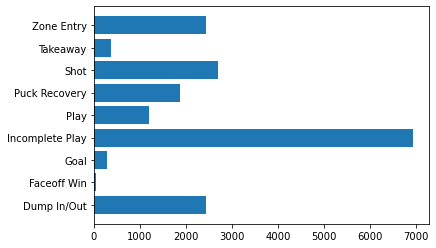

In [20]:
temp1 = data[data.possEnd == True].groupby(['Event'])['possEnd'].count().reset_index()
plt.barh(temp1.Event, temp1.possEnd)
plt.show()

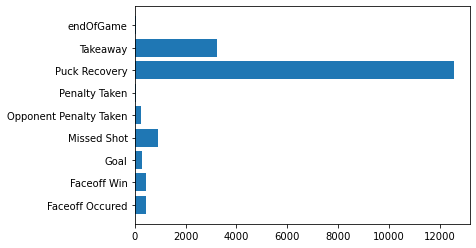

In [21]:
temp2 = data[data.possEnd == True].groupby(['possEndReasons'])['possEnd'].count().reset_index()
plt.barh(temp2.possEndReasons, temp2.possEnd)
plt.show()

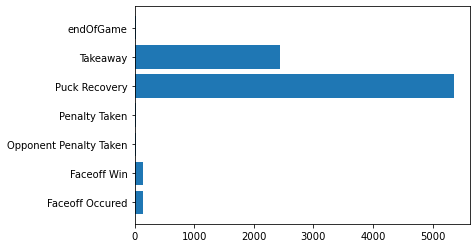

In [22]:
temp3 = data[(data.possEnd == True) & (data.Event.isin(['Incomplete Play', 'Play']))].groupby(['possEndReasons'])['possEnd'].count().reset_index()
plt.barh(temp3.possEndReasons, temp3.possEnd)
plt.show()

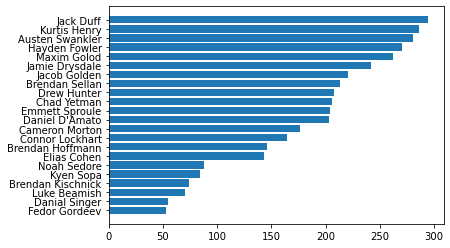

In [24]:
temp4 = data[(data.Event.isin(['Incomplete Play', 'Play']))].groupby(['Player', 'possEnd'])['Event'].count().reset_index().sort_values(by='Event', ascending=True)
plt.barh(temp4[(temp4.possEnd == True) & (temp4.Event > 50)].Player, temp4[(temp4.possEnd == True) & (temp4.Event > 50)].Event)
plt.show()

In [27]:
temp5 = temp4.copy()
temp5 = temp5.pivot(index='Player', columns='possEnd', values='Event').reset_index()
temp5.columns = ['Player', 'notEnded', 'Ended']
temp5['total'] = temp5['notEnded'] + temp5['Ended']
temp5['pct'] = (temp5['Ended'] / (temp5['total']))
temp5 = temp5.sort_values(by='pct', ascending= False)
temp5.head()

,Player,notEnded,Ended,total,pct
71,Chad Denault,1.0,3.0,4.0,0.750000
298,Michael Stubbs,1.0,2.0,3.0,0.666667
228,Kallaway Mercer,1.0,2.0,3.0,0.666667
64,Cameron Peters,6.0,10.0,16.0,0.625000
107,Daniel Walker,4.0,6.0,10.0,0.600000


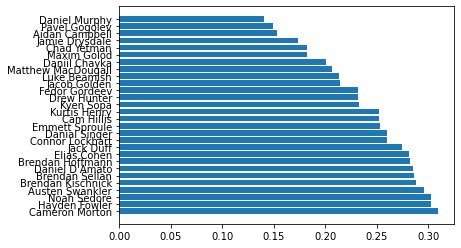

In [28]:
plt.barh(temp5[temp5.total > 160].Player, temp5[temp5.total > 160].pct)
plt.show()